  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNSIT/MNIST/raw/train-images-idx3-ubyte.gz to ./MNSIT/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNSIT/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNSIT/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNSIT/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNSIT/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNSIT/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNSIT/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The label of the image is 8


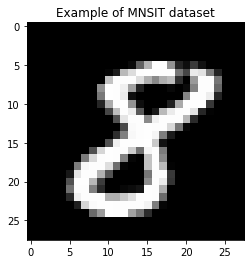

In [4]:
import torchvision.datasets as datasets
from torch import nn
from torchvision.transforms import Compose, Resize, ToTensor, ColorJitter, CenterCrop, Grayscale, Normalize
import torch.nn.functional as F
from torch import optim
import torch
from matplotlib import pyplot as plt
import numpy as np


batch_size = 8192

mnist_trainset = datasets.MNIST(root='./MNSIT', train=True, download=True, transform=Compose([Resize(size=28),
                                                                                     ToTensor()]))

mnist_testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=None)

train_dataLoader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True, num_workers=4)

images, labels = next(iter(train_dataLoader))

print("The label of the image is {}".format(labels[15]))
fig, ax = plt.subplots(figsize=(8,4))
plt.imshow(images[15].reshape(28,28), cmap="gray")
ax.set_title("Example of MNSIT dataset")

plt.show()

In [5]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 50)
        torch.nn.init.xavier_uniform_(self.fc1.weight, gain=1.0)
        self.fc2 = nn.Linear(50, 2)
        torch.nn.init.xavier_uniform_(self.fc2.weight, gain=1.0)
        self.fc3 = nn.Linear(2, 784)
        torch.nn.init.xavier_uniform_(self.fc3.weight, gain=1.0)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x
    
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 50)
        torch.nn.init.xavier_uniform_(self.fc1.weight, gain=1.0)
        self.fc2 = nn.Linear(50, 10)
        torch.nn.init.xavier_uniform_(self.fc2.weight, gain=1.0)
        self.fc3 = nn.Linear(10, 784)
        torch.nn.init.xavier_uniform_(self.fc3.weight, gain=1.0)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#loss_fn = nn.MSELoss()
loss_fn = F.mse_loss

In [8]:
model = Net1()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Create figure for plotting
%matplotlib notebook
plt.ion()
fig, ax = plt.subplots(ncols=3, figsize=(8,4))
fig.subplots_adjust(wspace=1)
plot_interval = 1


# Create arrays to save all of the metrics throughout training
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Train the model
for epoch in range(20):
    if epoch%2==0:
        print("epoch number: {}".format(epoch))
    for i, (b_x, b_y) in enumerate(train_dataLoader):
        b_x, b_y = b_x.to(device), b_y.to(device)
        b_x = b_x.view(-1,784)
        target = b_x.clone()
        
        pred = model(b_x)
        
        loss = loss_fn(pred, target)
    
        # Back-propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Save them in the arrays
        train_losses.append(loss.item())
        
        if epoch%2==0:
            #print some output results during this epoch run
            pred = pred.cpu()
            pred = pred.detach().numpy()
            target = target.cpu()
            target = target.detach().numpy()

            
            ax[0].imshow(target[105].reshape(28,28), cmap="gray")
            ax[0].set_title('Original')
            ax[1].imshow(pred[105].reshape(28,28), cmap="gray")
            ax[1].set_title('Reproduced')
            plt.show()
        
        if i % plot_interval == 0:
            # Update plots
            ax[2].clear()
            ax[2].plot(train_losses)

            # Add legends and labels
            ax[2].set_title('Loss')
            ax[2].set_xlabel('Number of iterations')
            fig.canvas.draw()
            plt.show()
            
            
torch.save(model.state_dict(), "Net1")

<IPython.core.display.Javascript object>

epoch number: 0
epoch number: 2
epoch number: 4
epoch number: 6
epoch number: 8
epoch number: 10
epoch number: 12
epoch number: 14
epoch number: 16
epoch number: 18


In [9]:
model = Net2()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Create figure for plotting
%matplotlib notebook
plt.ion()
fig, ax = plt.subplots(ncols=3, figsize=(8,4))
fig.subplots_adjust(wspace=1)
plot_interval = 1


# Create arrays to save all of the metrics throughout training
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Train the model
for epoch in range(20):
    if epoch%2==0:
        print("epoch number: {}".format(epoch))
    for i, (b_x, b_y) in enumerate(train_dataLoader):
        b_x, b_y = b_x.to(device), b_y.to(device)
        b_x = b_x.view(-1,784)
        target = b_x.clone()
        
        pred = model(b_x)
        
        loss = loss_fn(pred, target)
    
        # Back-propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Save them in the arrays
        train_losses.append(loss.item())
        
        if epoch%2==0:
            #print some output results during this epoch run
            pred = pred.cpu()
            pred = pred.detach().numpy()
            target = target.cpu()
            target = target.detach().numpy()

            
            ax[0].imshow(target[105].reshape(28,28), cmap="gray")
            ax[0].set_title('Original')
            ax[1].imshow(pred[105].reshape(28,28), cmap="gray")
            ax[1].set_title('Reproduced')
        
        if i % plot_interval == 0:
            # Update plots
            ax[2].clear()
            ax[2].plot(train_losses)

            # Add legends and labels
            ax[2].set_title('Loss')
            ax[2].set_xlabel('Number of iterations')
            fig.canvas.draw()
            plt.show()
            
            
torch.save(model.state_dict(), "Net2")

<IPython.core.display.Javascript object>

epoch number: 0
epoch number: 2
epoch number: 4
epoch number: 6
epoch number: 8
epoch number: 10
epoch number: 12
epoch number: 14
epoch number: 16
epoch number: 18


In [17]:
model1 = Net1()
model1.load_state_dict(torch.load('Net1'))
model1.to(device)

model2 = Net2()
model2.load_state_dict(torch.load('Net2'))
model2.to(device)



b_x, b_y = next(iter(train_dataLoader))
b_x, b_y = b_x.to(device), b_y.to(device)
b_x = b_x.view(-1,784)



target = b_x.clone()
pred = model1(b_x)
pred2 = model2(b_x)



# Remove objects from CUDA in order to convert them to numpy
b_y = b_y.cpu()
b_y = b_y.detach().numpy()
pred = pred.cpu()
pred = pred.detach().numpy()
pred2 = pred2.cpu()
pred2 = pred2.detach().numpy()
target = target.cpu()
target = target.detach().numpy()



fig, ax = plt.subplots(nrows=10,ncols=3, figsize=(12,10))
fig.subplots_adjust(hspace=0.6)


rowIndex = 0
for i in range(10):
    imageIndex = np.random.choice(np.where(b_y == i)[0], 1)
    ax[rowIndex][0].imshow(target[imageIndex].reshape(28,28), cmap="gray")
    ax[rowIndex][1].imshow(pred[imageIndex].reshape(28,28), cmap="gray")
    ax[rowIndex][2].imshow(pred2[imageIndex].reshape(28,28), cmap="gray")
    rowIndex += 1
    if rowIndex==9:
        ax[rowIndex][0].set_xlabel("Originals")
        ax[rowIndex][1].set_xlabel("Reproduced from network 1")
        ax[rowIndex][2].set_xlabel("Reproduced from network 2")
        
plt.show()

<IPython.core.display.Javascript object>

In [18]:
class Net1_encoder(Net1):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
class Net1_decoder(Net1):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        x = F.relu(self.fc3(x))
        return x

model = Net1_encoder()
model.load_state_dict(torch.load('Net1'))
model.to(device)

train_dataLoader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, 
                                               shuffle=True, num_workers=4)

b_x, b_y = next(iter(train_dataLoader))
b_x, b_y = b_x.to(device), b_y.to(device)

b_x = b_x.view(-1,784)

bottleneck = model(b_x)


# Remove objects from CUDA in order to convert them to numpy
b_y = b_y.cpu()
b_y = b_y.detach().numpy()
bottleneck = bottleneck.cpu()
bottleneck = bottleneck.detach().numpy()


fig, ax = plt.subplots(figsize=(8,6))
plt.ioff()

#Plot well reproducible digits
for digitStr,colour,digit in zip(('One','Three','Nine'),('r','g','b'),(1,3,9)):
    well_digits = bottleneck[np.where(b_y == digit)[0]]
    plt.scatter(well_digits[:,0], well_digits[:,1], c=colour, label=digitStr)

#Plot digits that don't seem well-reproducible
for digitStr,col,digit in zip(('Zero','Three','Four', 'Five', 'Six', 'Seven', 'Eight')
                                 ,('c','y','m','k',  [(.2, .2, .2)], [(.5, .5, .5)], [(.7, .7, .7)]),
                                 (0,2,4,5,6,7,8)):
    well_digits = bottleneck[np.where(b_y == digit)[0]]
    plt.scatter(well_digits[:,0], well_digits[:,1], c=col, label=digitStr, alpha=0.2)

plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [15]:
model = Net1_decoder()
model.load_state_dict(torch.load('Net1'))

train_dataLoader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, 
                                               shuffle=True, num_workers=4)


# Use values here from the previous scatter plot
encoded_images = torch.tensor([[ 1., 100.],
                               [1., 10.],
                               [11., 5.,]])



images = model(encoded_images)


#Convert to numpy for imshow
images = images.detach().numpy()



#Plotting
fig, ax = plt.subplots(ncols=3, figsize=(8,6))
plt.ioff()
for i in range(3):
    ax[i].imshow(images[i].reshape(28,28), cmap="gray")

    
plt.show()

<IPython.core.display.Javascript object>